In [185]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
from functools import reduce
import pandas as pd
from pyspark.sql.functions import col, expr, percentile_approx
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import to_date
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt
import os
from pymongo import MongoClient
from datetime import datetime
import numpy as np
import math

# Start Spark session
spark = SparkSession.builder \
    .appName("OPSData") \
    .config("spark.mongodb.input.uri", "mongodb://localhost/opsd.power_data") \
    .config("spark.mongodb.output.uri", "mongodb://localhost/opsd.power_data") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Optional: reduce log noise
spark.sparkContext.setLogLevel("WARN")


In [186]:
base_path = os.path.expanduser("~/Documents/SparkNotebooks/opsd")
file_name = "time_series_60min_singleindex.csv"

file_path = os.path.join(base_path, file_name)

df = spark.read.csv(file_path, header=True, inferSchema=True)

# Dataset is really wide and can't be viewed properly in notebooks
df.show(5)


+-------------------+-------------------+----------------------------------+------------------------------------+------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+-------------------------+----------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+-----------------+--------------------------+------------------------+---------------------------------+----------------------------------+------------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------

In [187]:
df.printSchema()         # See all the columns and data types

root
 |-- utc_timestamp: timestamp (nullable = true)
 |-- cet_cest_timestamp: timestamp (nullable = true)
 |-- AT_load_actual_entsoe_transparency: double (nullable = true)
 |-- AT_load_forecast_entsoe_transparency: double (nullable = true)
 |-- AT_price_day_ahead: double (nullable = true)
 |-- AT_solar_generation_actual: double (nullable = true)
 |-- AT_wind_onshore_generation_actual: double (nullable = true)
 |-- BE_load_actual_entsoe_transparency: double (nullable = true)
 |-- BE_load_forecast_entsoe_transparency: double (nullable = true)
 |-- BE_solar_generation_actual: double (nullable = true)
 |-- BE_wind_generation_actual: double (nullable = true)
 |-- BE_wind_offshore_generation_actual: double (nullable = true)
 |-- BE_wind_onshore_generation_actual: double (nullable = true)
 |-- BG_load_actual_entsoe_transparency: double (nullable = true)
 |-- BG_load_forecast_entsoe_transparency: double (nullable = true)
 |-- BG_solar_generation_actual: double (nullable = true)
 |-- BG_wind_on

In [188]:
df.columns               # Get list of column names

['utc_timestamp',
 'cet_cest_timestamp',
 'AT_load_actual_entsoe_transparency',
 'AT_load_forecast_entsoe_transparency',
 'AT_price_day_ahead',
 'AT_solar_generation_actual',
 'AT_wind_onshore_generation_actual',
 'BE_load_actual_entsoe_transparency',
 'BE_load_forecast_entsoe_transparency',
 'BE_solar_generation_actual',
 'BE_wind_generation_actual',
 'BE_wind_offshore_generation_actual',
 'BE_wind_onshore_generation_actual',
 'BG_load_actual_entsoe_transparency',
 'BG_load_forecast_entsoe_transparency',
 'BG_solar_generation_actual',
 'BG_wind_onshore_generation_actual',
 'CH_load_actual_entsoe_transparency',
 'CH_load_forecast_entsoe_transparency',
 'CH_solar_capacity',
 'CH_solar_generation_actual',
 'CH_wind_onshore_capacity',
 'CH_wind_onshore_generation_actual',
 'CY_load_actual_entsoe_transparency',
 'CY_load_forecast_entsoe_transparency',
 'CY_wind_onshore_generation_actual',
 'CZ_load_actual_entsoe_transparency',
 'CZ_load_forecast_entsoe_transparency',
 'CZ_solar_generation_

In [189]:
# Number of columns
len(df.columns)

300

In [190]:
df.select("utc_timestamp", "IE_load_actual_entsoe_transparency").show(10)

+-------------------+----------------------------------+
|      utc_timestamp|IE_load_actual_entsoe_transparency|
+-------------------+----------------------------------+
|2015-01-01 01:00:00|                              NULL|
|2015-01-01 02:00:00|                            2832.0|
|2015-01-01 03:00:00|                            2678.0|
|2015-01-01 04:00:00|                            2432.0|
|2015-01-01 05:00:00|                            2276.0|
|2015-01-01 06:00:00|                            2173.0|
|2015-01-01 07:00:00|                            2136.0|
|2015-01-01 08:00:00|                            2166.0|
|2015-01-01 09:00:00|                            2215.0|
|2015-01-01 10:00:00|                            2237.0|
+-------------------+----------------------------------+
only showing top 10 rows



In [191]:
# Count rows
df.count()

50401

In [192]:
# Basic stats on a numeric column
df.describe("IE_load_actual_entsoe_transparency").show()

+-------+----------------------------------+
|summary|IE_load_actual_entsoe_transparency|
+-------+----------------------------------+
|  count|                             49837|
|   mean|                3191.2216425547285|
| stddev|                 608.6479345942973|
|    min|                            1790.0|
|    max|                            5018.0|
+-------+----------------------------------+



In [193]:
# Get null counts
nulls = df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
])

# Convert to Pandas and sort by null count
nulls_pd = nulls.toPandas().T
nulls_pd.columns = ['null_count']
nulls_pd = nulls_pd.sort_values(by='null_count', ascending=False)

# Show top 20 columns with most nulls
nulls_pd.head(20)


,null_count
HR_solar_generation_actual,50391
HR_wind_onshore_generation_actual,50379
PT_wind_offshore_generation_actual,47509
PT_wind_generation_actual,47509
PL_solar_generation_actual,46237
HU_solar_generation_actual,41436
SK_wind_onshore_generation_actual,40722
NO_5_wind_onshore_generation_actual,40132
NO_1_wind_onshore_generation_actual,35815
DE_LU_load_forecast_entsoe_transparency,33745


In [194]:
# Show 20 columns with least nulls
nulls_pd.tail(20)

,null_count
BE_load_actual_entsoe_transparency,1
DE_amprion_load_forecast_entsoe_transparency,1
DE_tennet_wind_onshore_generation_actual,1
DE_amprion_load_actual_entsoe_transparency,1
DE_50hertz_load_forecast_entsoe_transparency,1
DE_50hertz_wind_generation_actual,1
DE_50hertz_wind_offshore_generation_actual,1
DE_50hertz_load_actual_entsoe_transparency,1
DE_50hertz_wind_onshore_generation_actual,1
DE_amprion_wind_onshore_generation_actual,1


### Preprocessing

In [195]:
# Drop duplicates
df_no_duplicates = df.dropDuplicates()
df_no_duplicates.count()

50401

In [196]:
%%script skipping
from pyspark.sql.functions import percentile_approx
from pyspark.sql.types import NumericType

# Function to compute median for a column (using percentile_approx)
def get_median(df, col_name):
    return df.select(percentile_approx(col_name, 0.5)).first()[0]

# Get numeric columns in the DataFrame
numeric_columns = [col for col, dtype in df.dtypes if isinstance(df.schema[col].dataType, NumericType)]

# Compute median values for all numeric columns in parallel
median_values = {}
for c in numeric_columns:
    try:
        median_val = get_median(df, c)
        median_values[c] = median_val
    except Exception as e:
        print(f"Skipping column {c}: {e}")

# Apply the fillna operation for all numeric columns with their respective medians
df_filled = df
for c, median_val in median_values.items():
    df_filled = df_filled.fillna({c: median_val})

df_filled.show(5)  # Show the first 5 rows of the filled DataFrame


Couldn't find program: 'skipping'


In [197]:
%%script skipping
#Print all DE columns
de_columns = [col for col in df_filled.columns if col.startswith("DE_")]
print(de_columns)

Couldn't find program: 'skipping'


In [198]:
%%script skipping
# Parse timestamp
df_filled = df_filled.withColumn("timestamp", to_timestamp("utc_timestamp"))
df_filled = df_filled.drop("utc_timestamp", "cet_cest_timestamp")  # drop original date columns

Couldn't find program: 'skipping'


In [199]:
# Get a list of country codes from the column names
country_codes = set(
    col.split('_')[0] for col in df.columns if len(col.split('_')) > 1 and len(col.split('_')[0]) == 2 and col.split('_')[0].isalpha()
)

print(country_codes)


{'CZ', 'PL', 'GR', 'HR', 'CH', 'AT', 'SI', 'FR', 'IE', 'RO', 'LU', 'FI', 'ME', 'RS', 'LT', 'HU', 'NL', 'CY', 'DE', 'PT', 'UA', 'ES', 'SK', 'SE', 'GB', 'BG', 'IT', 'BE', 'DK', 'LV', 'EE', 'NO'}


In [200]:
%%script skipping
# Let's start with german data only (DE)
de_cols = [col for col in df_filled.columns if col.startswith("DE_")]
selected_columns = ["timestamp"] + de_cols
de_df = df_filled.select(*selected_columns)

Couldn't find program: 'skipping'


In [201]:
# Setup MongoDB connection
client = MongoClient("mongodb://localhost:27017/")
collection = client["opsd"]["power_data"]

In [202]:
%%script skipping
print(df_filled.columns)

Couldn't find program: 'skipping'


In [203]:
print(df.columns)

['utc_timestamp', 'cet_cest_timestamp', 'AT_load_actual_entsoe_transparency', 'AT_load_forecast_entsoe_transparency', 'AT_price_day_ahead', 'AT_solar_generation_actual', 'AT_wind_onshore_generation_actual', 'BE_load_actual_entsoe_transparency', 'BE_load_forecast_entsoe_transparency', 'BE_solar_generation_actual', 'BE_wind_generation_actual', 'BE_wind_offshore_generation_actual', 'BE_wind_onshore_generation_actual', 'BG_load_actual_entsoe_transparency', 'BG_load_forecast_entsoe_transparency', 'BG_solar_generation_actual', 'BG_wind_onshore_generation_actual', 'CH_load_actual_entsoe_transparency', 'CH_load_forecast_entsoe_transparency', 'CH_solar_capacity', 'CH_solar_generation_actual', 'CH_wind_onshore_capacity', 'CH_wind_onshore_generation_actual', 'CY_load_actual_entsoe_transparency', 'CY_load_forecast_entsoe_transparency', 'CY_wind_onshore_generation_actual', 'CZ_load_actual_entsoe_transparency', 'CZ_load_forecast_entsoe_transparency', 'CZ_solar_generation_actual', 'CZ_wind_onshore_ge

In [204]:
df = df.withColumn("timestamp", to_timestamp("utc_timestamp"))
df = df.drop("utc_timestamp", "cet_cest_timestamp")  # drop original date columns

In [230]:
import math

# Function to process and insert data
def process_columns(df):
    timestamp_col = "timestamp"
    country_cols = {}

    # Organize columns by country prefix
    for col_name in df.columns:
        if col_name == timestamp_col:
            continue
        parts = col_name.split("_")
        country_prefix = parts[0]
        
        # Handle multi-country prefixes like 'DE_LU'
        if len(parts) > 1 and ('price' in parts[1] or 'generation' in parts[1] or 'capacity' in parts[1]):
            countries = country_prefix.split("_")
            for c in countries:
                country_cols.setdefault(c, []).append(col_name)
        else:
            country_cols.setdefault(country_prefix, []).append(col_name)

    docs = []
    
    # Collect the rows from the PySpark DataFrame as a list of Row objects
    rows = df.collect()

    # Process each row
    for row in rows:
        timestamp = row[timestamp_col]

        for country, cols in country_cols.items():
            doc = {
                "timestamp": timestamp,
                "country": country,
                "consumption": 0,
                "consumption_forecast": 0,
                "price_day_ahead": 0,
                "generation": {},
                "capacity": {},
                "profile": {}
            }

            # Process each relevant column for the country
            for col_name in cols:
                value = row[col_name]

                if value is None or (isinstance(value, (float, int)) and math.isnan(value)):
                    continue

                parts = col_name.split("_")
                field = "_".join(parts[1:])

                if "load_actual" in field and "transnetbw" not in field and "tennet" not in field and "amprion" not in field and "50hertz" not in field and "LU" not in field:
                    doc["consumption"] = float(value)
                elif "load_forecast" in field and "transnetbw" not in field and "tennet" not in field and "amprion" not in field and "50hertz" not in field and "LU" not in field:
                    doc["consumption_forecast"] = float(value)
                elif "price_day_ahead" in field:
                    doc["price_day_ahead"] = float(value)
                elif "generation" in field:
                    key = field.replace("_generation", "")
                    doc["generation"][f"{key}_generation"] = float(value)
                elif "capacity" in field:
                    key = field.replace("_capacity", "")
                    doc["capacity"][f"{key}_capacity"] = float(value)
                elif "profile" in field:
                    key = field.replace("_profile", "")
                    doc["profile"][f"{key}_profile"] = float(value)

            docs.append(doc)

    # Insert the documents into MongoDB if any are prepared
    if docs:
        try:
            collection.insert_many(docs)
            print(f"{len(docs)} documents inserted successfully.")  # Debugging line
        except Exception as e:
            print("Error inserting documents:", e)  # Debugging line

# Call the function to process the DataFrame
process_columns(df)


1612832 documents inserted successfully.


In [206]:
%%script skipping
# Define the fields for generation, capacity, and profile
generation_fields = ["solar_generation", "wind_generation", "wind_onshore_generation", "wind_offshore_generation"]
capacity_fields = ["solar_capacity", "wind_capacity", "wind_offshore_capacity", "wind_onshore_capacity"]
profile_fields = ["solar_profile", "wind_profile", "wind_offshore_profile", "wind_onshore_profile"]

# Define the renaming template for each country (example with 'DE')
rename_template = {
    "load_actual_entsoe_transparency": "consumption",
    "price_day_ahead": "price_day_ahead",
    "load_forecast_entsoe_transparency": "consumption_forecast",
    "solar_capacity": "solar_capacity",
    "solar_generation_actual": "solar_generation",
    "solar_profile": "solar_profile",
    "wind_capacity": "wind_capacity",
    "wind_generation_actual": "wind_generation",
    "wind_profile": "wind_profile",
    "wind_offshore_capacity": "wind_offshore_capacity",
    "wind_offshore_generation_actual": "wind_offshore_generation",
    "wind_offshore_profile": "wind_offshore_profile",
    "wind_onshore_capacity": "wind_onshore_capacity",
    "wind_onshore_generation_actual": "wind_onshore_generation",
    "wind_onshore_profile": "wind_onshore_profile"
}

def row_to_dict(row, country):
    row_dict = row.asDict()

    # Generate dictionaries for generation, capacity, and profile
    generation = {
        k: row_dict.get(k, None)
        for k in generation_fields if k in row_dict
    }
    capacity = {
        k: row_dict.get(k, None)
        for k in capacity_fields if k in row_dict
    }
    profile = {
        k: row_dict.get(k, None)
        for k in profile_fields if k in row_dict
    }

    # Return the structured dictionary to insert into MongoDB
    return {
        "timestamp": row_dict.get("timestamp", None),
        "country": country,  # Dynamic country
        "consumption": row_dict.get("consumption", None),
        "consumption_forecast": row_dict.get("consumption_forecast", None),
        "price_day_ahead": row_dict.get("price_day_ahead", None),
        "generation": generation,
        "capacity": capacity,
        "profile": profile
    }

# Only process country code 'DE' for testing
country = 'DE'

# Filter columns that start with the country code 'DE'
country_columns = [col for col in df_filled.columns if col.startswith(f"{country}_")]
#print(country_columns)

# Create a dynamic renaming map for the country
rename_map = {f"{country}_{key}": f"{value}" for key, value in rename_template.items()}
#print(rename_map)

# Filter the rename map to only include columns in the country-specific DataFrame
rename_map = {old: new for old, new in rename_map.items() if old in country_columns}
#print(rename_map)

# Select columns for the current country and rename them based on the rename map
country_df = df_filled.select(*country_columns)
for old_col, new_col in rename_map.items():
    country_df = country_df.withColumnRenamed(old_col, new_col)
    #print(f"Renamed {old_col} to {new_col}")
    
# Debugging: Show the DataFrame schema and the first few rows after renaming
country_df.printSchema()
country_df.show(5)

# Convert to an RDD and apply the row_to_dict function to structure the data
rdd_docs = country_df.rdd.map(lambda row: row_to_dict(row, country))

# Collect the data to insert into MongoDB
data_to_insert = rdd_docs.collect()

# Insert into MongoDB if there is data for this country
if data_to_insert:
    collection.insert_many(data_to_insert)
    print(f"Data for {country} inserted successfully.")
else:
    print(f"No data found for {country}.")


Couldn't find program: 'skipping'


In [207]:
%%script skipping
# Loop through each country code
for country in country_codes:
    # Filter columns that start with the country code
    country_columns = [col for col in df.columns if col.startswith(f"{country}_")]

    # Create a dynamic renaming map for the country
    rename_map = {f"{country}_{key}": f"{country}_{value}" for key, value in rename_template.items()}

    # Filter the rename map to only include columns in the country-specific DataFrame
    rename_map = {old: new for old, new in rename_map.items() if old in country_columns}

    # Select columns for the current country and rename them based on the rename map
    country_df = df.select(*country_columns)
    for old_col, new_col in rename_map.items():
        country_df = country_df.withColumnRenamed(old_col, new_col)

    # Convert to an RDD and apply the row_to_dict function to structure the data
    rdd_docs = country_df.rdd.map(lambda row: row_to_dict(row, country))

    # Collect the data to insert into MongoDB
    data_to_insert = rdd_docs.collect()

    # Insert into MongoDB if there is data for this country
    if data_to_insert:
        collection.insert_many(data_to_insert)
        print(f"Data for {country} inserted successfully.")
    else:
        print(f"No data found for {country}.")

Couldn't find program: 'skipping'


### Data to MongoDB

In [208]:
%%script skipping
# Rename columns for easier access
rename_map = {
    "DE_load_actual_entsoe_transparency": "consumption",
    "DE_LU_price_day_ahead": "price_day_ahead",
    "DE_load_forecast_entsoe_transparency": "consumption_forecast",
    "DE_solar_capacity": "solar_capacity",
    "DE_solar_generation_actual": "solar_generation",
    "DE_solar_profile": "solar_profile",
    "DE_wind_capacity": "wind_capacity",
    "DE_wind_generation_actual": "wind_generation",
    "DE_wind_profile": "wind_profile",
    "DE_wind_offshore_capacity": "wind_offshore_capacity",
    "DE_wind_offshore_generation_actual": "wind_offshore_generation",
    "DE_wind_offshore_profile": "wind_offshore_profile",
    "DE_wind_onshore_capacity": "wind_onshore_capacity",
    "DE_wind_onshore_generation_actual": "wind_onshore_generation",
    "DE_wind_onshore_profile": "wind_onshore_profile",
    "DE_50hertz_load_actual_entsoe_transparency": "consumption_50hertz",
    "DE_50hertz_wind_onshore_generation_actual": "wind_onshore_50hertz",
    "DE_LU_load_actual_entsoe_transparency": "consumption_LU",
    "DE_LU_load_forecast_entsoe_transparency": "consumption_forecast_LU",
    "DE_LU_solar_generation_actual": "solar_generation_LU",
    "DE_LU_wind_generation_actual": "wind_generation_LU",
    "DE_LU_wind_offshore_generation_actual": "wind_offshore_LU",
    "DE_LU_wind_onshore_generation_actual": "wind_onshore_LU",
    "DE_amprion_load_actual_entsoe_transparency": "consumption_amprion",
    "DE_amprion_load_forecast_entsoe_transparency": "consumption_forecast_amprion",
    "DE_amprion_solar_generation_actual": "solar_amprion",
    "DE_amprion_wind_generation_actual": "wind_amprion",
    "DE_tennet_load_actual_entsoe_transparency": "consumption_tennet",
    "DE_tennet_load_forecast_entsoe_transparency": "consumption_forecast_tennet",
    "DE_tennet_solar_generation_actual": "solar_tennet",
    "DE_tennet_wind_generation_actual": "wind_tennet",
    "DE_tennet_wind_offshore_generation_actual": "wind_offshore_tennet",
    "DE_tennet_wind_onshore_generation_actual": "wind_onshore_tennet",
    "DE_transnetbw_load_actual_entsoe_transparency": "consumption_transnetbw",
    "DE_transnetbw_load_forecast_entsoe_transparency": "consumption_forecast_transnetbw",
    "DE_transnetbw_solar_generation_actual": "solar_transnetbw",
    "DE_transnetbw_wind_onshore_generation_actual": "wind_onshore_transnetbw"
}

for old_col, new_col in rename_map.items():
    de_df = de_df.withColumnRenamed(old_col, new_col)

Couldn't find program: 'skipping'


In [209]:
%%script skipping
# Convert rows to dictionarys for MongoDB
# Define the fields to extract for generation, capacity, and profile
generation_fields = ["solar_generation", "wind_generation", "wind_onshore_generation", "wind_offshore_generation"]  # extend this list
capacity_fields = ["solar_capacity", "wind_capacity", "wind_offshore_capacity", "wind_onshore_capacity"]
profile_fields = ["solar_profile", "wind_profile", "wind_offshore_profile", "wind_onshore_profile"]

def row_to_dict(row):
    row_dict = row.asDict()
    generation = {
        k: row_dict.get(k, None)
        for k in generation_fields if k in row_dict
    }
    capacity = {
        k: row_dict.get(k, None)
        for k in capacity_fields if k in row_dict
    }
    profile = {
        k: row_dict.get(k, None)
        for k in profile_fields if k in row_dict
    }
    return {
        "timestamp": row_dict["timestamp"],
        "country": "DE",
        "consumption": row_dict.get("consumption", None),
        "consumption_forecast": row_dict.get("consumption_forecast", None),
        "price_day_ahead": row_dict.get("price_day_ahead", None),
        "generation": generation,
        "capacity": capacity,
        "profile": profile       
    }

rdd_docs = de_df.rdd.map(row_to_dict)

Couldn't find program: 'skipping'


In [210]:
%%script skipping
# Setup MongoDB connection
client = MongoClient("mongodb://localhost:27017/")
collection = client["opsd"]["power_data"]

Couldn't find program: 'skipping'


In [211]:
%%script skipping
from pymongo.errors import BulkWriteError

# Convert the PySpark DataFrame to a list of dictionaries
documents = de_df.rdd.map(lambda row: row.asDict()).collect()

try:
    for i in range(0, len(documents), 1000):  # batch of 1000
        collection.insert_many(documents[i:i+1000])
except BulkWriteError as bwe:
    print("Bulk write error:", bwe.details)

Couldn't find program: 'skipping'


### Data from MongoDB

In [212]:
%%script skipping
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, MapType, DateType

# Define the schema
schema = StructType([
    StructField("_id", MapType(StringType(), StringType()), True),  # Handle MongoDB _id field
    StructField("timestamp", DateType(), True),  # Convert timestamp to DateType
    StructField("country", StringType(), True),
    StructField("consumption", DoubleType(), True),
    StructField("consumption_forecast", DoubleType(), True),
    StructField("price_day_ahead", DoubleType(), True),
    StructField("generation", MapType(StringType(), DoubleType()), True),  # Treat generation as a map
    StructField("capacity", MapType(StringType(), DoubleType()), True),  # Treat capacity as a map
    StructField("profile", MapType(StringType(), DoubleType()), True)   # Treat profile as a map
])

# Read data from MongoDB with the defined schema
df_read = spark.read.format("mongo").schema(schema).load()

# Show schema and a few records
df_read.printSchema()


Couldn't find program: 'skipping'


In [213]:
# Read data from MongoDB with the defined schema
df_read = spark.read.format("mongo").load()

# Filter for data where country is 'DE'
df_de = df_read.filter(df_read.country == "DE")

# Show the filtered data for DE
df_de.show(10, truncate=False)

+--------------------------+----------------------------------------------------------------------------------------------+-----------+--------------------+-------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+--------------------------------------------------------+-------------------+
|_id                       |capacity                                                                                      |consumption|consumption_forecast|country|generation                                                                                                                                                                                           

In [214]:
df_read.columns

['_id',
 'capacity',
 'consumption',
 'consumption_forecast',
 'country',
 'generation',
 'price_day_ahead',
 'profile',
 'timestamp']

In [215]:
from pyspark.sql.functions import avg, to_date, col  # Ensure avg, to_date, and col are correctly imported

# Read from MongoDB
df_read = spark.read.format("mongo").load()

# Print the schema to understand the structure of the data
df_read.printSchema()

# Filter for data where country is 'DE'
df_de = df_read.filter(df_read.country == "DE")

# Show the first few rows of the DataFrame
df_de.show(5)

# Extract the 'timestamp', 'wind_actual_generation', and 'solar_actual_generation' columns, and convert 'timestamp' to a date
# Extract fields from the 'generation' struct
df_mongo = df_de.select(
    "timestamp",
    col("generation.wind_actual_generation").alias("wind_actual_generation"),
    col("generation.solar_actual_generation").alias("solar_actual_generation")
).withColumn("date", to_date(col("timestamp")))

# Calculate daily averages of both wind and solar generation in one step
daily_avg_df = df_mongo.groupBy("date").agg(
    avg("wind_actual_generation").alias("avg_wind_generation"),
    avg("solar_actual_generation").alias("avg_solar_generation")
)

# Sort by date
daily_avg_df = daily_avg_df.orderBy("date")

# Show the daily averages
daily_avg_df.show(20)


root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- capacity: struct (nullable = true)
 |    |-- GBN_solar_capacity: double (nullable = true)
 |    |-- GBN_wind_capacity: double (nullable = true)
 |    |-- GBN_wind_offshore_capacity: double (nullable = true)
 |    |-- GBN_wind_onshore_capacity: double (nullable = true)
 |    |-- NIR_solar_capacity: double (nullable = true)
 |    |-- NIR_wind_onshore_capacity: double (nullable = true)
 |    |-- UKM_solar_capacity: double (nullable = true)
 |    |-- UKM_wind_capacity: double (nullable = true)
 |    |-- UKM_wind_offshore_capacity: double (nullable = true)
 |    |-- UKM_wind_onshore_capacity: double (nullable = true)
 |    |-- solar_capacity: double (nullable = true)
 |    |-- wind_capacity: double (nullable = true)
 |    |-- wind_offshore_capacity: double (nullable = true)
 |    |-- wind_onshore_capacity: double (nullable = true)
 |-- consumption: double (nullable = true)
 |-- consumption_forecast: double 

In [ ]:
%%script skipping
from pyspark.sql.functions import avg, to_date, col  # Ensure avg, to_date, and col are correctly imported

# Read from MongoDB
df_read = spark.read.format("mongo").load()

df_read.printSchema()

# Filter for data where country is 'DE'
df_de = df_read.filter(df_read.country == "DE")

# Show the first few rows of the DataFrame
df_de.show(5)
# Extract the 'timestamp' and 'wind_generation' columns, and convert 'timestamp' to a date
df_mongo = df_de.select(
    "timestamp",
    "generation.wind_actual_generation",
    "generation.solar_actual_generation"
).withColumn("date", to_date(col("timestamp")))

# Calculate daily average of wind AND SOLAR generation
# Calculate daily averages of both wind and solar generation in one step
daily_avg_df = df_mongo.groupBy("date").agg(
    avg("generation.wind_actual_generation").alias("avg_wind_generation"),
    avg("generation.solar_actual_generation").alias("avg_solar_generation")
)

# Sort by date
daily_avg_df = daily_avg_df.orderBy("date")

# Show the daily averages
daily_avg_df.show(20)

UsageError: Line magic function `%script` not found (But cell magic `%%script` exists, did you mean that instead?).


### Plotting

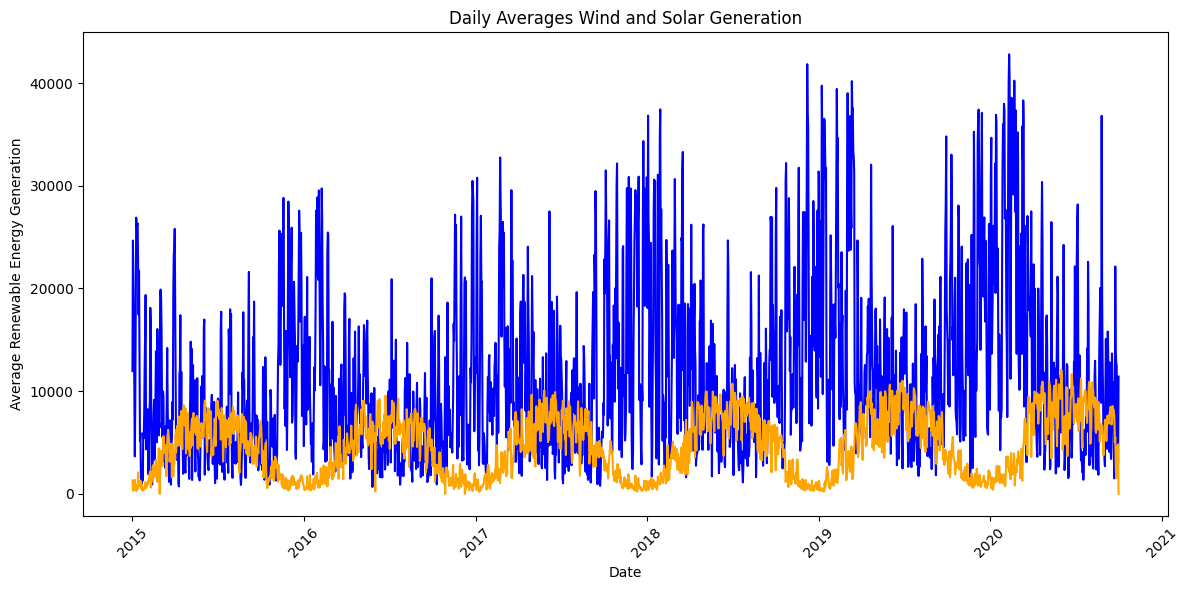

In [217]:
import seaborn as sns

# Convert the PySpark DataFrame to a Pandas DataFrame
daily_avg_pd = daily_avg_df.toPandas()

# Create the seaborn line plot for wind and solar generation
plt.figure(figsize=(12, 6))
#sns.lineplot(x='date', y='avg_wind_generation', data=daily_avg_pd)
plt.plot(daily_avg_pd['date'], daily_avg_pd['avg_wind_generation'], label='Wind Generation', color='blue')
plt.plot(daily_avg_pd['date'], daily_avg_pd['avg_solar_generation'], label='Solar Generation', color='orange')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Average Renewable Energy Generation')
plt.title('Daily Averages Wind and Solar Generation')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


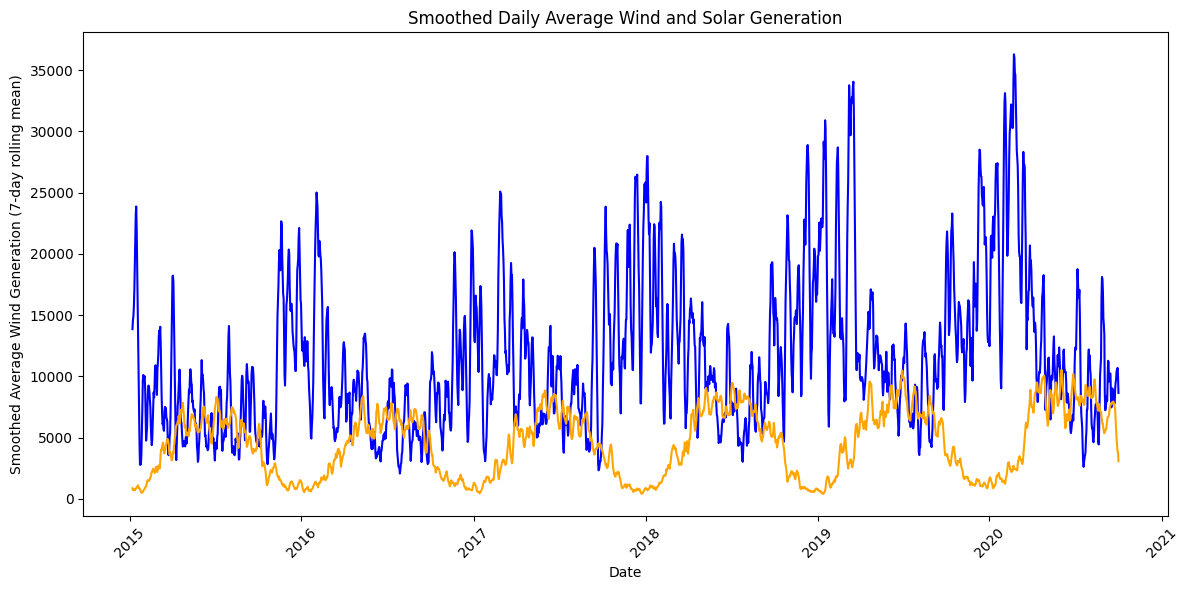

In [218]:
# Calculate a 7-day rolling average for smoother lines
daily_avg_pd['rolling_avg_wind'] = daily_avg_pd['avg_wind_generation'].rolling(window=7).mean()
daily_avg_pd['rolling_avg_solar'] = daily_avg_pd['avg_solar_generation'].rolling(window=7).mean()

# Plot the smoothed line (rolling average)
plt.figure(figsize=(12, 6))
#sns.lineplot(x='date', y='rolling_avg', data=daily_avg_pd, color='orange')
plt.plot(daily_avg_pd['date'], daily_avg_pd['rolling_avg_wind'], label='Wind Generation', color='blue')
plt.plot(daily_avg_pd['date'], daily_avg_pd['rolling_avg_solar'], label='Solar Generation', color='orange')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Smoothed Average Wind Generation (7-day rolling mean)')
plt.title('Smoothed Daily Average Wind and Solar Generation')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [223]:
df_read.createOrReplaceTempView("generation_data")

# Query using SparkSQL
sql_query = """
    SELECT
        to_date(timestamp) AS date,
        AVG(generation.wind_actual_generation) AS avg_wind_generation,
        AVG(generation.solar_actual_generation) AS avg_solar_generation
    FROM generation_data
    WHERE country = 'DE'
    GROUP BY date
    ORDER BY date
"""

# Run the SQL query
daily_avg_df_sql = spark.sql(sql_query)

# Show the result
daily_avg_df_sql.show(20)

+----------+-------------------+--------------------+
|      date|avg_wind_generation|avg_solar_generation|
+----------+-------------------+--------------------+
|2015-01-01|            11951.1|  1315.2307692307693|
|2015-01-02|          24670.125|   323.2083333333333|
|2015-01-03| 20597.541666666668|   301.5416666666667|
|2015-01-04|           16706.25|   832.5833333333334|
|2015-01-05|          10783.125|  1105.0833333333333|
|2015-01-06|           3653.875|  1370.3333333333333|
|2015-01-07|  8599.458333333334|   713.0833333333334|
|2015-01-08|          16999.875|   358.2916666666667|
|2015-01-09|           26895.75|              284.25|
|2015-01-10| 25876.666666666668|   853.0416666666666|
|2015-01-11| 26227.666666666668|   825.4583333333334|
|2015-01-12| 26347.916666666668|             459.375|
|2015-01-13| 22571.583333333332|            2095.125|
|2015-01-14| 17446.333333333332|   754.4166666666666|
|2015-01-15| 21736.083333333332|   714.7916666666666|
|2015-01-16| 13659.208333333

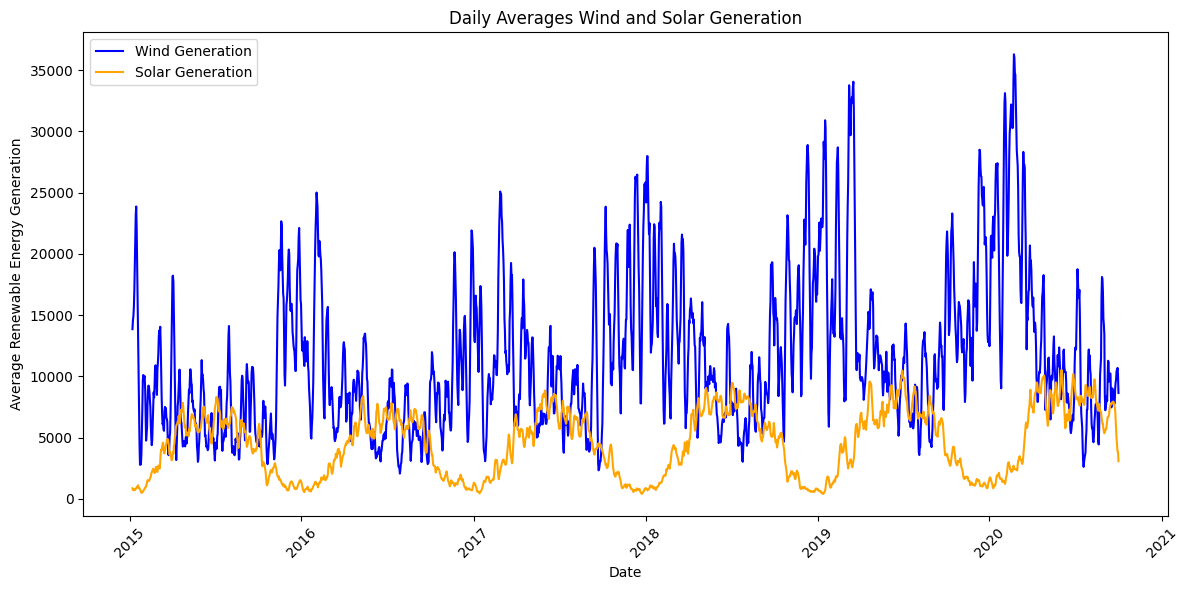

In [224]:
# Lets plot the data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame
daily_avg_pd_sql = daily_avg_df_sql.toPandas()
daily_avg_pd_sql['date'] = pd.to_datetime(daily_avg_pd_sql['date'])
daily_avg_pd_sql.set_index('date', inplace=True)
daily_avg_pd_sql = daily_avg_pd_sql.resample('D').mean()
daily_avg_pd_sql = daily_avg_pd_sql.interpolate(method='linear')
daily_avg_pd_sql = daily_avg_pd_sql.rolling(window=7).mean()
daily_avg_pd_sql = daily_avg_pd_sql.dropna()
daily_avg_pd_sql.reset_index(inplace=True)
daily_avg_pd_sql['date'] = pd.to_datetime(daily_avg_pd_sql['date'])

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(daily_avg_pd_sql['date'], daily_avg_pd_sql['avg_wind_generation'], label='Wind Generation', color='blue')
plt.plot(daily_avg_pd_sql['date'], daily_avg_pd_sql['avg_solar_generation'], label='Solar Generation', color='orange')
plt.xlabel('Date')
plt.ylabel('Average Renewable Energy Generation')
plt.title('Daily Averages Wind and Solar Generation')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [ ]:
df_read.createOrReplaceTempView("generation_data")

# Query using SparkSQL
sql_query = """
    SELECT
        to_date(timestamp) AS date,
        SUM(generation.wind_actual_generation + generation.solar_actual_generation) AS total_renewables_generation,
        SUM(consumption) AS total_consumption
    FROM generation_data
    WHERE country = 'DE'
    GROUP BY date
    ORDER BY date
"""

# Run the SQL query
daily_sum_df_sql = spark.sql(sql_query)

# Show the result
daily_sum_df_sql.show(20)

+----------+---------------------------+-----------------+
|      date|total_renewables_generation|total_consumption|
+----------+---------------------------+-----------------+
|2015-01-01|                   190730.0|         902871.0|
|2015-01-02|                   599840.0|        1242370.0|
|2015-01-03|                   501578.0|        1122658.0|
|2015-01-04|                   420932.0|        1080173.0|
|2015-01-05|                   285317.0|        1303330.0|
|2015-01-06|                   120581.0|        1330926.0|
|2015-01-07|                   223501.0|        1429312.0|
|2015-01-08|                   416596.0|        1479137.0|
|2015-01-09|                   652320.0|        1464001.0|
|2015-01-10|                   641513.0|        1264778.0|
|2015-01-11|                   649275.0|        1156133.0|
|2015-01-12|                   643375.0|        1460583.0|
|2015-01-13|                   592001.0|        1471824.0|
|2015-01-14|                   436818.0|        1456718.

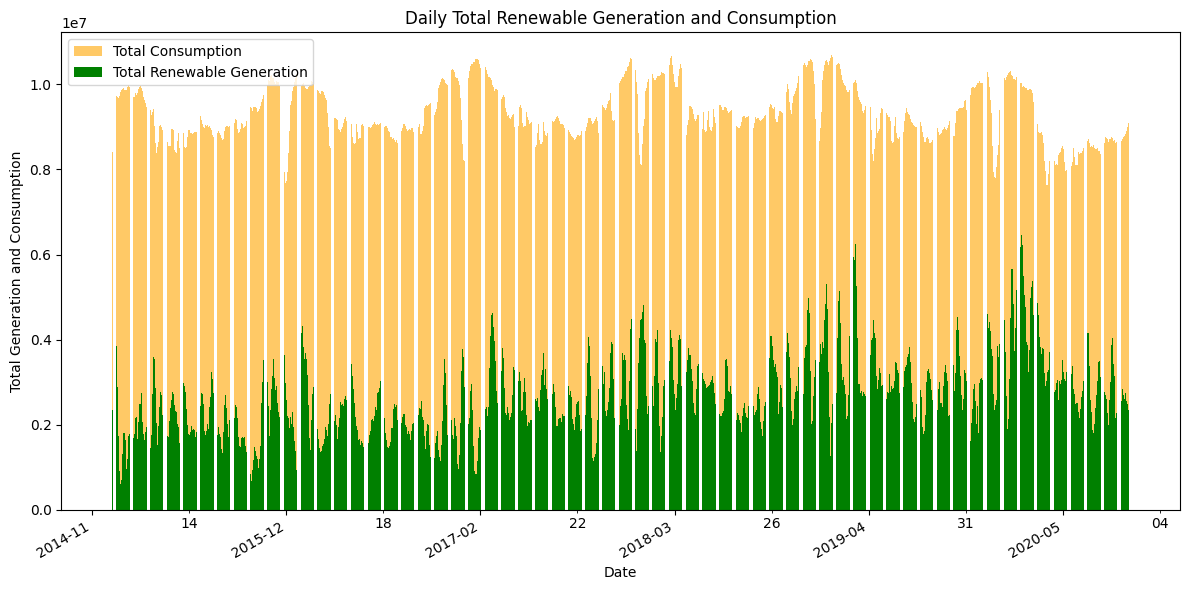

In [235]:
#Lets' plot the data as a bar plot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


# Convert the PySpark DataFrame to a Pandas DataFrame
daily_sum_pd_sql = daily_sum_df_sql.toPandas()
daily_sum_pd_sql['date'] = pd.to_datetime(daily_sum_pd_sql['date'])
daily_sum_pd_sql.set_index('date', inplace=True)
daily_sum_pd_sql = daily_sum_pd_sql.resample('D').sum()
daily_sum_pd_sql = daily_sum_pd_sql.interpolate(method='linear')
daily_sum_pd_sql = daily_sum_pd_sql.rolling(window=7).sum()
daily_sum_pd_sql = daily_sum_pd_sql.dropna()
daily_sum_pd_sql.reset_index(inplace=True)
daily_sum_pd_sql['date'] = pd.to_datetime(daily_sum_pd_sql['date'])


# Plot the data
plt.figure(figsize=(12, 6))
plt.bar(daily_sum_pd_sql['date'], daily_sum_pd_sql['total_consumption'], label='Total Consumption', color='orange', alpha=0.6)
plt.bar(daily_sum_pd_sql['date'], daily_sum_pd_sql['total_renewables_generation'], label='Total Renewable Generation', color='green', alpha=1)
plt.xlabel('Date')
plt.ylabel('Total Generation and Consumption')
plt.title('Daily Total Renewable Generation and Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_minor_locator(mdates.DayLocator())
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6, prune='both'))
plt.gca().xaxis.set_minor_locator(ticker.MaxNLocator(nbins=12, prune='both'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [240]:
df_read.createOrReplaceTempView("generation_data")

# Query using SparkSQL
sql_query = """
    SELECT
        year(timestamp) AS year,
        weekofyear(timestamp) AS week,
        SUM(generation.solar_actual_generation) AS total_solar_generation,
        SUM(generation.wind_actual_generation) AS total_wind_generation,
        SUM(capacity.solar_capacity) AS total_solar_capacity,
        SUM(capacity.wind_capacity) AS total_wind_capacity
    FROM
        generation_data_2
    WHERE
        country = 'DE'
    GROUP BY
        year, week
    ORDER BY
        year, week
"""

# Run the SQL query
weekly_gen_df_sql = spark.sql(sql_query)

# Show the result
weekly_gen_df_sql.show(20)

+----+----+----------------------+---------------------+--------------------+-------------------+
|year|week|total_solar_generation|total_wind_generation|total_solar_capacity|total_wind_capacity|
+----+----+----------------------+---------------------+--------------------+-------------------+
|2015|   1|               52074.0|            1726396.0|           3464202.0|          2596806.0|
|2015|   2|              132229.0|            2856874.0|           6259146.0|          4697334.0|
|2015|   3|              172051.0|            2708927.0|           6261129.0|          4702869.0|
|2015|   4|               97130.0|             471037.0|           6265710.0|          4712088.0|
|2015|   5|              130888.0|            1668804.0|           6272676.0|          4724121.0|
|2015|   6|              254387.0|            1290609.0|           6277404.0|          4740306.0|
|2015|   7|              300430.0|            1013624.0|           6278145.0|          4753443.0|
|2015|   8|         

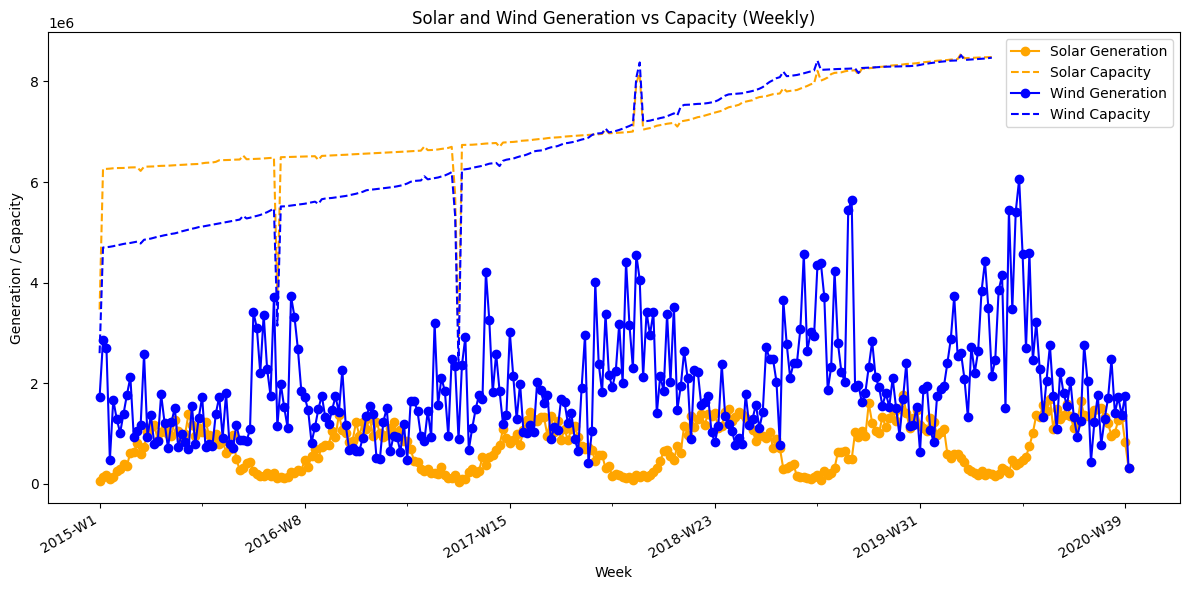

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming result_df is the DataFrame containing the query results
# Convert the Spark DataFrame to Pandas for easier plotting
result_pd = weekly_gen_df_sql.toPandas()

# Create a new column for the week (combining year and week number)
result_pd['week_label'] = result_pd['year'].astype(str) + '-W' + result_pd['week'].astype(str)

# Plotting the data
plt.figure(figsize=(12, 6))

# Plot solar generation vs capacity
plt.plot(result_pd['week_label'], result_pd['total_solar_generation'], label='Solar Generation', color='orange', marker='o')
plt.plot(result_pd['week_label'], result_pd['total_solar_capacity'], label='Solar Capacity', color='orange', linestyle='--')

# Plot wind generation vs capacity
plt.plot(result_pd['week_label'], result_pd['total_wind_generation'], label='Wind Generation', color='blue', marker='o')
plt.plot(result_pd['week_label'], result_pd['total_wind_capacity'], label='Wind Capacity', color='blue', linestyle='--')

# Adding labels and title
plt.xlabel('Week')
plt.ylabel('Generation / Capacity')
plt.title('Solar and Wind Generation vs Capacity (Weekly)')
plt.legend()

# Rotate x-axis labels for better readability
#add years to x-axis labels
plt.xticks(rotation=45)
# Set x-axis major locator to show every 4 weeks
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(4))

plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6, prune='both'))
plt.gca().xaxis.set_minor_locator(ticker.MaxNLocator(nbins=12, prune='both'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


In [ ]:
# Convert the PySpark DataFrame to a Pandas DataFrame
daily_avg_pd_sql = daily_avg_df_sql.toPandas()
daily_avg_pd_sql['date'] = pd.to_datetime(daily_avg_pd_sql['date'])
daily_avg_pd_sql.set_index('date', inplace=True)
daily_avg_pd_sql = daily_avg_pd_sql.resample('D').mean()
daily_avg_pd_sql = daily_avg_pd_sql.interpolate(method='linear')
daily_avg_pd_sql = daily_avg_pd_sql.rolling(window=7).mean()
daily_avg_pd_sql = daily_avg_pd_sql.dropna()
daily_avg_pd_sql.reset_index(inplace=True)
daily_avg_pd_sql['date'] = pd.to_datetime(daily_avg_pd_sql['date'])

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(daily_avg_pd_sql['date'], daily_avg_pd_sql['avg_wind_generation'], label='Wind Generation', color='blue')
plt.plot(daily_avg_pd_sql['date'], daily_avg_pd_sql['avg_solar_generation'], label='Solar Generation', color='orange')
plt.xlabel('Date')
plt.ylabel('Average Renewable Energy Generation')
plt.title('Daily Averages Wind and Solar Generation')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [ ]:
from pyspark.sql import functions as F
## do spark sql query on wind generation by months
# Read from MongoDB


# Ensure the 'date' column is created from the 'timestamp' column
df = df.withColumn("date", F.to_date("timestamp"))

# Extract year and month from the 'date' column
df = df.withColumn("year", F.year("date")).withColumn("month", F.month("date"))

# Combine all wind generation columns into a single column for aggregation
wind_generation_columns = [
    "BE_wind_generation_actual", "DE_wind_generation_actual", 
    "DK_wind_generation_actual", "NL_wind_generation_actual", 
    "PT_wind_generation_actual"
]

# Sum all wind generation columns into a new column
df = df.withColumn("wind_generation", sum(F.col(col) for col in wind_generation_columns))

# Calculate total wind generation by year and month
monthly_total_df = df.groupBy("year", "month").agg(
    F.sum("wind_generation").alias("total_wind_generation")
)

# Sort by total wind generation in descending order
monthly_total_df = monthly_total_df.orderBy("total_wind_generation", ascending=False)

# Show the results
monthly_total_df.show(20)


In [ ]:
# Convert to Pandas DataFrame for easier plotting
monthly_total_pd = monthly_total_df.toPandas()

# Create a bar plot for the months with the highest wind generation
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='total_wind_generation', data=monthly_total_pd, hue='year')

# Set plot labels and title
plt.xlabel('Month')
plt.ylabel('Total Wind Generation')
plt.title('Total Wind Generation by Month')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Read solar_generation data from MongoDB (assuming similar structure as wind_generation)
df_solar = spark.read.format("mongo").load()

# Extract the necessary columns for solar generation
df_solar_filtered = df_solar.select(
    "timestamp",
    "generation.solar_generation"
).withColumn("date", to_date(col("timestamp")))

# Join the solar generation data with the wind generation data on 'date'
df_combined = df_filtered.join(
    df_solar_filtered,
    on="date",
    how="inner"  # Inner join ensures we only keep matching dates
)

In [ ]:
# Calculate total energy generation by adding wind_generation and solar_generation
df_combined = df_combined.withColumn(
    "total_generation",
    col("wind_generation") + col("solar_generation")
)


In [ ]:
# Fetch consumption data from MongoDB (assuming it's structured similarly)
df_consumption = spark.read.format("mongo").load()

# Extract the necessary columns for consumption
df_consumption_filtered = df_consumption.select(
    "timestamp",
    "consumption"
).withColumn("date", to_date(col("timestamp")))

# Join the consumption data with the combined generation data on 'date'
df_final = df_combined.join(
    df_consumption_filtered,
    on="date",
    how="inner"  # We want to match the same date
)


In [ ]:
# Calculate if total generation meets or exceeds consumption
df_final = df_final.withColumn(
    "generation_vs_consumption",
    col("total_generation") - col("consumption")
)

# Group by date and calculate daily totals for generation, consumption, and the difference
daily_comparison_df = df_final.groupBy("date").agg(
    sum("total_generation").alias("total_generation"),
    sum("consumption").alias("total_consumption"),
    sum("generation_vs_consumption").alias("net_generation")
)

# Sort by date
daily_comparison_df = daily_comparison_df.orderBy("date")

# Show the results
daily_comparison_df.show(20)


In [ ]:
# Convert to Pandas DataFrame for visualization
daily_comparison_pd = daily_comparison_df.toPandas()

# Plot the comparison of total generation vs total consumption
plt.figure(figsize=(12, 6))

# Plot both total generation and total consumption
sns.lineplot(x='date', y='total_generation', data=daily_comparison_pd, label='Total Generation', color='blue')
sns.lineplot(x='date', y='total_consumption', data=daily_comparison_pd, label='Total Consumption', color='red')

# Add a title and labels
plt.title('Total Energy Generation vs Consumption')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')

# Display legend
plt.legend()

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Extract year and month from the 'date' column
df_final = df_final.withColumn("year", F.year("date")).withColumn("month", F.month("date"))

# Aggregate by month and year
monthly_summary_df = df_final.groupBy("year", "month").agg(
    F.sum("total_generation").alias("monthly_generation"),
    F.sum("consumption").alias("monthly_consumption"),  # Corrected column name
    F.sum("generation_vs_consumption").alias("net_generation")
)

# Calculate renewable energy percentage for each month
monthly_summary_df = monthly_summary_df.withColumn(
    "renewable_energy_percentage",
    (col("monthly_generation") / col("monthly_consumption")) * 100
)

# Sort by year and month
monthly_summary_df = monthly_summary_df.orderBy("year", "month")

# Show the monthly summary
monthly_summary_df.show()


In [ ]:
# Convert to Pandas DataFrame for easier plotting
monthly_summary_pd = monthly_summary_df.toPandas()

# Combine year and month into a single column for better x-axis labels
monthly_summary_pd['month_year'] = monthly_summary_pd['month'].astype(str) + '-' + monthly_summary_pd['year'].astype(str)

# Plot the renewable energy percentage month by month
plt.figure(figsize=(12, 6))
sns.barplot(x='month_year', y='renewable_energy_percentage', data=monthly_summary_pd, color='green')

# Set plot labels and title
plt.xlabel('Month-Year')
plt.ylabel('Renewable Energy Percentage')
plt.title('Monthly Renewable Energy Contribution to Consumption')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()
